In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import date
import seaborn as sns
from scipy.signal import argrelextrema
import contextlib
import io

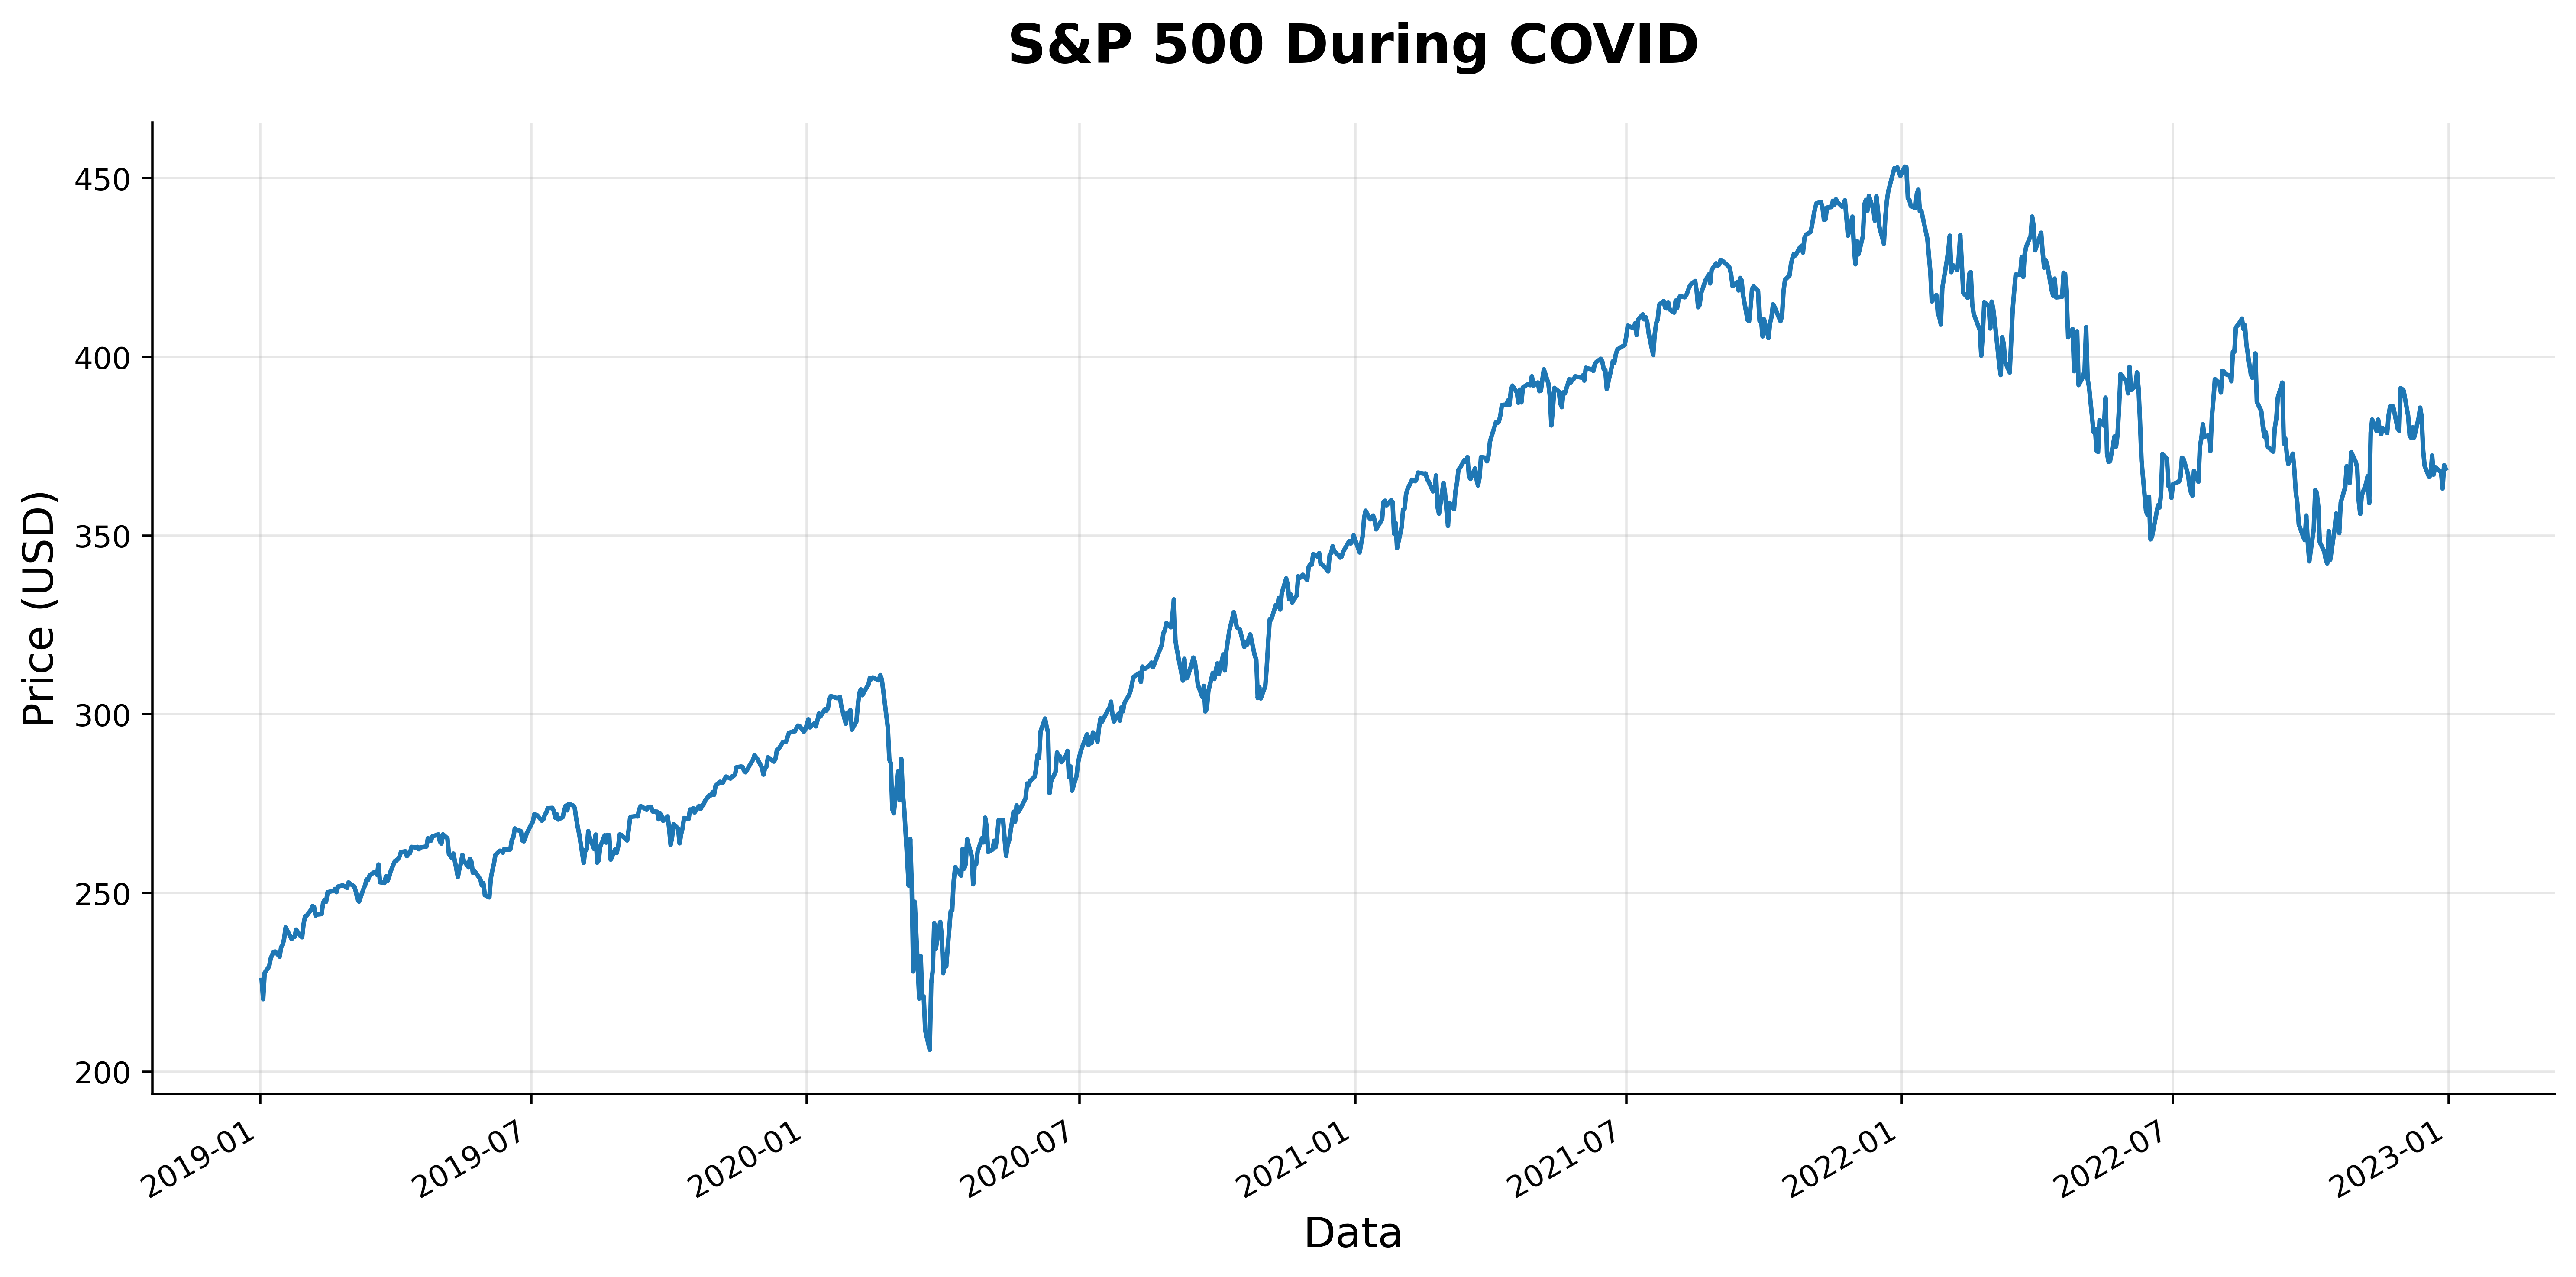

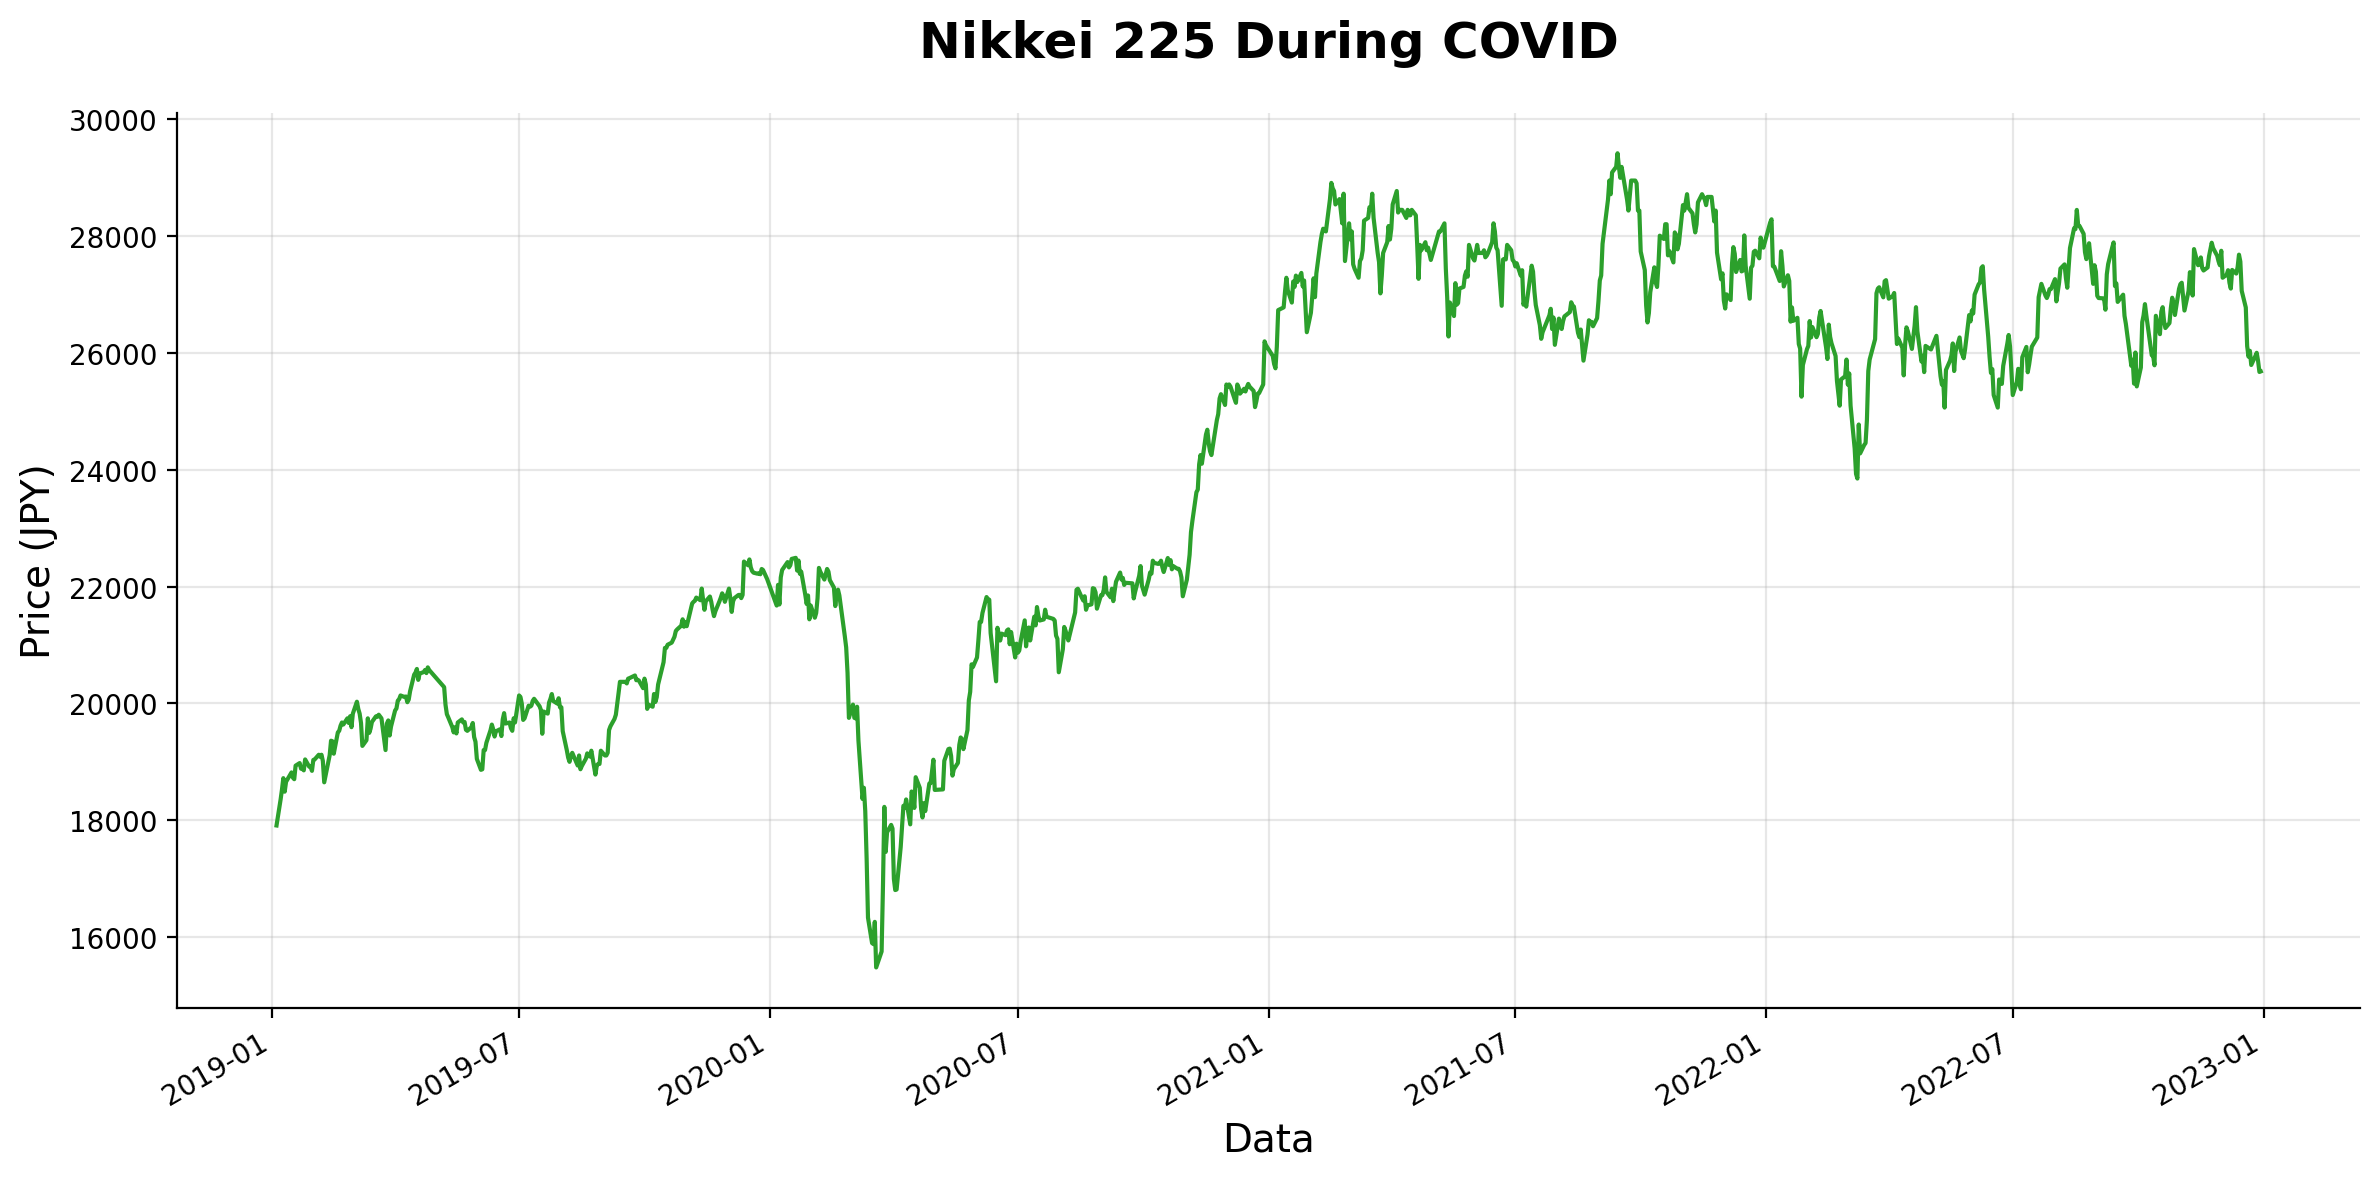

In [ ]:
start = "2019-01-01"
end = "2022-12-31"

spy = yf.download("SPY", start = start, end = end, auto_adjust=False, progress=False)["Adj Close"]
# Changing to the normal table:
spy = spy.reset_index()
spy.columns = ['Date', 'Price']


nikkei = yf.download("1321.T", start = start, end = end, auto_adjust=False, progress=False)["Adj Close"]
# Changing to the normal table:
nikkei = nikkei.reset_index()
nikkei.columns = ['Date', 'Price']

#####  Plotting the Graphs.  #####

### S&P 500
plt.figure(figsize=(12,6), dpi=500)

sns.lineplot(
    data=spy,
    x = "Date",
    y="Price",
    color="#1f77b4",
    linewidth=1.5,
)

plt.title("S&P 500 During COVID", fontsize = 18, weight = "bold", pad = 20 )
plt.xlabel("Data", fontsize = 14)
plt.ylabel("Price (USD)", fontsize = 14)

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
sns.despine()
plt.grid(True, alpha=0.3)

plt.show()

### NIKKEI ###
plt.figure(figsize=(12,6), dpi=200)

sns.lineplot(
    data=nikkei,
    x = "Date",
    y="Price",
    color="#2ca02c",
    linewidth=1.5,
)

plt.title("Nikkei 225 During COVID", fontsize = 18, weight = "bold", pad = 20 )
plt.xlabel("Data", fontsize = 14)
plt.ylabel("Price (JPY)", fontsize = 14)

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
sns.despine()
plt.grid(True, alpha=0.3)

plt.show()


In [4]:
precrash="2020-03-01"
target_price = 311

mask = spy["Date"] <= precrash
max_row = spy.loc[mask].loc[spy.loc[mask, "Price"].idxmax()]
print(max_row["Date"].strftime("%Y-%m-%d"))
print(max_row["Price"])

mask = (spy["Date"] > precrash) & (spy["Price"] >= target_price)
if mask.any():
    recovery_row = spy.loc[mask].iloc[0]
    recovery_date = recovery_row["Date"].strftime("%Y-%m-%d")
    recovery_price = recovery_row["Price"]
    print(f"We hit it on {recovery_date} @ {recovery_date}")
else:
    print("Stock has not recovered")
    recovery_date = None
    recovery_price = None



2020-02-19
310.95855712890625
We hit it on 2020-08-10 @ 2020-08-10


### Finding Crash Date

In [5]:
def detect_market_phases(data, precrash="2020-03-01", peakdate="2020-02-01"):
    """
    Detect market crash and recovery phases.
    
    Parameters:
    - data: pandas Series with DatetimeIndex (e.g., stock prices)
    - precrash: Search for peak before this date
    - peakdate: Start searching for trough from this date
    """

    
    # Find peak price before the crash
    mask_pre = data["Date"] <= precrash
    max_row_pre = data.loc[mask_pre].loc[data.loc[mask_pre, "Price"].idxmax()]

    peak_date = max_row_pre["Date"].strftime("%Y-%m-%d")
    peak_price = max_row_pre["Price"]

    # Find trough (lowest point) after peak
    mask_tr = data["Date"] >= peakdate
    min_row_tr = data.loc[mask_tr].loc[data.loc[mask_tr, "Price"].idxmin()]
    
    trough_date = min_row_tr["Date"].strftime("%Y-%m-%d")
    trough_price = min_row_tr["Price"]
    
    # Find recovery date (when price returns to peak level)
    mask = (data["Date"] > trough_date) & (data["Price"] >= peak_price)
    if mask.any():
        recovery_row = data.loc[mask].iloc[0]
        recovery_date = recovery_row["Date"].strftime("%Y-%m-%d")
        recovery_price = recovery_row["Price"]
        print(f"We hit it on {recovery_date} @ {recovery_date}")
    else:
        print("Stock has not recovered")
        recovery_date = None
        recovery_price = None
    
    # Print results
    print("\n📊═══════════════════════════════════════════════════════📊")
    print("               📉  Market Phase Detection  📉")
    print("═════════════════════════════════════════════════════════")
    print(f"📈 Peak (Pre-Crash)     : {peak_date}   @ ${peak_price:,.2f}")
    print(f"📉 Trough (Crash Bottom): {trough_date}   @ ${trough_price:,.2f}")

    if recovery_date:
        print(f"✅ Recovery             : {recovery_date}   → Back above pre-crash level (${recovery_price:,.2f})")
    else:
        print("❌ Recovery             : Not yet reached pre-crash value")

    print("═════════════════════════════════════════════════════════\n")
    
    return {
        "peak_date": peak_date,
        "peak_price": peak_price,
        "trough_date": trough_date,
        "trough_price": trough_price,
        "recovery_date": recovery_date,
        "recovery_price": recovery_price,
        "crash_period": (peak_date, trough_date),
        "recovery_period": (trough_date, recovery_date) if recovery_date else None,
        "postcovid_period": (recovery_date, data.index[-1]) if recovery_date else None
    }

In [6]:
detect_market_phases(spy);
detect_market_phases(nikkei);

# Saving it silently
with contextlib.redirect_stdout(io.StringIO()):
    us_phase = detect_market_phases(spy)
    japan_phase = detect_market_phases(nikkei)

We hit it on 2020-08-10 @ 2020-08-10

📊═══════════════════════════════════════════════════════📊
               📉  Market Phase Detection  📉
═════════════════════════════════════════════════════════
📈 Peak (Pre-Crash)     : 2020-02-19   @ $310.96
📉 Trough (Crash Bottom): 2020-03-23   @ $206.11
✅ Recovery             : 2020-08-10   → Back above pre-crash level ($311.59)
═════════════════════════════════════════════════════════

We hit it on 2020-11-04 @ 2020-11-04

📊═══════════════════════════════════════════════════════📊
               📉  Market Phase Detection  📉
═════════════════════════════════════════════════════════
📈 Peak (Pre-Crash)     : 2020-01-20   @ $22,491.51
📉 Trough (Crash Bottom): 2020-03-19   @ $15,483.88
✅ Recovery             : 2020-11-04   → Back above pre-crash level ($22,544.14)
═════════════════════════════════════════════════════════



In [ ]:
# Saving them in to the file

phase_data = pd.DataFrame([
    {"Market": "US (S&P500)", **us_phase},
    {"Market": "Japan (Nikkei225)", **japan_phase}
])

phase_data.to_csv("/Users/lex/CodeProjects/Corporate Finance/Data/market_phases.csv", index = False)